# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/home/ec2-user/data/moviereviews_train.tsv', my_random_seed=74)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 5541, 'TN': 4695, 'FP': 5272, 'FN': 4492, 'Accuracy': 0.5118, 'Precision': 0.5124387311569407, 'Recall': 0.552277484301804, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 9633, 'TN': 9811, 'FP': 156, 'FN': 400, 'Accuracy': 0.9722, 'Precision': 0.9840637450199203, 'Recall': 0.9601315658327519, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 10033, 'Neg': 9967, 'TP': 5223, 'TN': 6699, 'FP': 3268, 'FN': 4810, 'Accuracy': 0.5961, 'Precision': 0.615121893769874, 'Recall': 0.5205820791388418, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

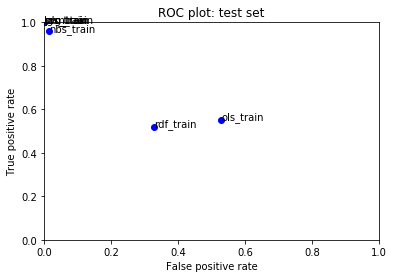

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
45
this movie wasn't absolutely atrocious, but it was pretty bad. the acting ACTUALLY was pretty good! jeffrey combs did a pretty darn good job as the mad scientist, which is sort of his specialty if you don't know such things :D. bill forsythe .. well, i'm not EXACTLY sure why he was in this film. he's way too good for this kinda stuff, and his role wasn't exactly demanding. I rented this on the strength of those two leads, and I wasn't really disappointed. I mean, heck, it's a movie about a half man/half shark. It ain't Shakespeare folks. Other than the plot, which is full of holes, and the poor dialogue, I would like to note that the cinematography also left many things to be desired. there were shots were they were trying to look \cool\", but it ended up obscuring the scene or just coming off plain cheezy. they also blew it many times when they had decent dialogue and cut away prematurely before the person could even deliver the line. it was pretty bad.

957
OK, If you're looking for another Bastketball Diaries, this is completely the wrong film.<br /><br />I revolves around two brothers. Max, the younger, has a major cocaine addiction. Adam, the eldest, is a doctor. This movie is suppose to show the plunge from reality to the extreme lows that drugs make possible. It however, does not. It shows that cocaine can be fun no matter what the situation happens to be present. Most of the movie focus is on Max and his parting ways. Eventually Adam, can no longer take the stress from his job and begins to use as well (perscription drugs).<br /><br />This movie has almost no climax. Doesn't descend into what cocaine really does to you, has boring and low-budget scenes, and the acting of the eldest brother, Adam, is horrific.<br /><br />I have no idea how this movie has managed to pass and receive awards, it is not a heart-wencher. If you want a clear and true story movie on the extreme world of drugs- rent, if not buy 'The Basketball Diaries'. 

* * * * * * * * * 
3822
\Steve\"(Chris Hoffman)gathers a group from high school for a reunion at the cabin location where his twin brother Wes went missing. While they are there, a reptilian creature in the shape of a man(reminded me a lot of the Gillman from CREATURE FROM THE BLACK LAGOON)awaits in the wilderness choosing the right time to pick them apart one by one. A biker, Ellen Ripley-type time female bad-ass, Kat(Chase Masterson)has an underground military bunker she practices experiments in, while it also serves as a place of safety from the thing on the bloody rampage. Kat knows more than she's telling(she also suffered the loss of a child), but there's another novelty twist most of the group have no idea of. This creature might just be more human than they realize..and it's former identity might shed some light on a deception only one other person has been hiding since Wes' death. Kat holds the key to many of the mysteries that unlock as the group remains near the cabin.<br />

4253
Normally, I am a pretty generous critic, but in the case of this film I have to say it was incredibly bad. I am stunned by how positive most reviews seem to be.<br /><br />There were some gorgeous shots, but it's too bad they were wasted on this sinkhole of a movie. It might have worked if \Daggers\" was purely an action flick and not a romance, but unfortunately the film is built around an empty love triangle. There is no chemistry between either of the couples, whatever exists between Mei and her men seems to be more lust than love, and for the most part the dialogue is just silly. This may be just a problem with translation, but the frequent usage of the word \"flirt\" in particular reminded me of 8th grade, not head-over-heels, together forever, worth-dying-for love; I also felt we were beat over the head with the wind metaphor. The audience is given very little about the characters to really care about, and therefore very little emotional investment in the movie as a whole. I

6818
I tried. I really did. I thought that maybe, if I gave Joao Pedro Rodrigues another chance, I could enjoy his movie. I know that after seeing O FANTASMA I felt ill and nearly disgusted to the core, but some of the reviews were quite good and in favor, so I was like, \What the hell. At least you didn't pay 10 dollars at the Quad. Give it a shot.\"<br /><br />Sometimes it's better to go to your dentist and ask for a root canal without any previous anesthetic to alleviate the horror of so much pain. I often wonder if it wouldn't be better to go back to my childhood and demand my former bullies to really let me have it. On other occasions, I often think that the world is really flat and that if I sail away far enough, I will not only get away from it all, but fall clear over, and that some evil, Lovecraftian thing will snatch me with its 9000 tentacles and squeeze the life -- and some french fries from 1995, still lingering inside my esophagus -- out of me.<br /><br />Is there a reaso

* * * * * * * * * 
7357
I remember when THE GOLDEN CHILD was released in 1986 it was universally panned by the critics , and I`m talking panned so badly that it more or less ended the glittering career of Eddie Murphy so I guess this movie has something going for it<br /><br />It gets off to a bad start where Buddist monks kneel in front of a child with a blank expression on his face . Bad guys enter the temple<br /><br />Child sits with blank expression<br /><br />Bad guys chop up the monks<br /><br />Child sits with blank expression<br /><br />Bad guys pull out giant bird cage and stick the child inside who now sits with ... Go on guess ? You do get the impression that even if they were taking him for a sleepover at Michael Jackson`s wonderland ranch he`d still give the same blank expression , this movie would be better titled THE WOODEN CHILD<br /><br />The title sequence starts and being a movie from the 1980s a pop soundtrack features heavily . Obviously this might have been cool 

10399
This really doesn't match up to Castle of Cagliostro. Lupin isn't as funny or wacky or as hyperactive. The scenery and music are uninspired and plot just isn't interesting. <br /><br />The only good thing about this 'un is the nudity (only in the uncut version) provided by Fujiko. It helped spice up some of the tedious scenes. CoC had a formidable villain and set up the movie for some imaginative set-pieces. The locations in TSoTG are not very vivid or engaging. <br /><br />Zenigata, Goemon and Jigen don't even provide decent sideshow entertainment this time. It's like they were just filling a contractual obligation by appearing. <br /><br />The DVD is in full-frame with Dolby Stereo sound. It has a decent amount of extras, including quite a few trailers. But one curious thing. There is no chapter selection on the disc or timecode displayed on the player once inserted. Though you can still skip to the next scene number using the remote.
* * * * * * * * * 
10405
For the initial 20

13771
I went into this film with expectations, from the hype, that it would be insightful and uplifting. Certainly something more than a cheap promotional for the band \Wilco.\"<br /><br />Instead we get a lot of moping and whining about \"the process,\" a dishonorable and no doubt one-sided portrayal of one band members who was kicked out by the prima donna lead singer/songwriter, a gut-wrenching confession by the fallen member's friend -- for like 18 years -- saying the \"friendship had run its course,\" and this whiny, uncompelling story about how one record label \"hurt their feelings\" by dumping them, only so that the band could immediately get 50 offers from other labels (oh, the tension...not!) They tried their best to make it look like it was a strain, but I suspect it was all smoke and mirrors to generate a tragedy that didn't exist. This doesn't even take into account the long stretches where we get many of their newest songs shoved at us in full without any storyline, insig

17164
This show is not clever. That's basically what it boils down to. The \original humor\" that these writers try to pull off to avoid completely biting off the rest of the worlds bush bashing is just unfunny. In another comment, someone quotes a couple hilarious lines. The standout for me was George H.W. Bush telling the kids they're not supposed to watch any TV besides Fox News. Wow. I thought the episodes I saw were bad. The fact that this line is a high point for the series is pathetic.<br /><br />My problem with drivel like this sad excuse for political satire is that these folks are getting a second season. I'm a liberal republican and I know Bush hasn't been a good president. We all do. But that's no excuse for putting out this utterly poopie waste of time. I place these writers on the same level as the geniuses behind 'Meet the Spartans'. Their formula, bite off as many already unfunny topical jokes as you can and throw in even worse original material to actually be able to g

18141
Yes. I'll admit it. I believed all the hype surrounding this piece of work, about the trials and tribulations of 6 people, living in Mexico City concerning their sexual lives. And so, I was really expecting to finally see a Mexican movie (in ages) that was both popular and interesting to watch. Unfortunately the film was utterly disappointing. The story presents us with two couples, both with very obvious marital problems. When a third party comes into the life of each couple, their problems reach a pivotal point. Or absolute absurd. The plot then turns into a battle of the sexes. The stance taken by each group (yes, they literally group, girls with girls and boys with boys) is blatantly stupid and childish (I guess the humor was supposed to be there). And it all goes from bad to worse. The performances range from good (Miss Zavaleta) to mediocre (Mr Bichir), with Serrano doing an acceptable job on his opera prima. However, the flat circumstances that make up the plot, the one-di

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1430, 'TN': 1126, 'FP': 1407, 'FN': 1037, 'Accuracy': 0.5112, 'Precision': 0.5040535777229468, 'Recall': 0.5796513984596676, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2035, 'TN': 2097, 'FP': 436, 'FN': 432, 'Accuracy': 0.8264, 'Precision': 0.8235532173209227, 'Recall': 0.8248885285772193, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2041, 'TN': 2093, 'FP': 440, 'FN': 426, 'Accuracy': 0.8268, 'Precision': 0.822652156388553, 'Recall': 0.8273206323469802, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1768, 'TN': 1907, 'FP': 626, 'FN': 699, 'Accuracy': 0.735, 'Precision': 0.7385129490392648, 'Recall': 0.7166599108228617, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2071, 'TN': 2084, 'FP': 449, 'FN': 396, 'Accuracy': 0.831, 'Precision': 0.8218253968253968, 'Recall': 0.8394811511957844, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2106, 'TN': 2101, 'FP': 432, 'FN': 361, 'Accuracy': 0.8414, 'Precision': 0.8297872340425532, 'Recall': 0.853668423186056, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1253, 'TN': 1725, 'FP': 808, 'FN': 1214, 'Accuracy': 0.5956, 'Precision': 0.6079573022804464, 'Recall': 0.5079043372517228, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

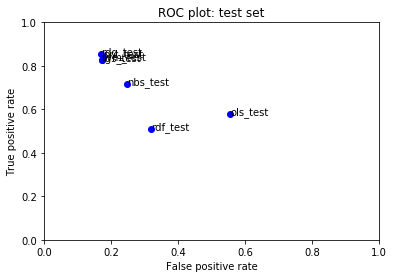

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation